In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import copy

def ativacao(x):
    y = 1/(1+np.exp(-x))
    yl = y*(1-y)
    return y, yl

def predicao(X,pesos):
    a = X.T
    for p in pesos:
        z = np.dot(p[0],a)+p[1]
        a,_ = ativacao(z)
    return a

def construir_pesos(lst):
    pesos = []
    for i in range(len(lst)-1):
        W = np.random.randn(lst[i+1],lst[i])
        b = np.random.randn(lst[i+1],1)
        pesos.append([W,b])
    
    return pesos

def avaliarn(X,pesos):
    a = X.T
    _,al = ativacao(a)
    res = [[a,al]]### verificar aqui
    for p in pesos:
        z = np.dot(p[0],a)+p[1]
        a,al = ativacao(z)
        res.append([a,al])
    
    return res

def metricas(y_real,y_predito):
    tam0,tam1 = len(y_real[y_real == 0]),len(y_real[y_real == 1])
    tam = tam0+tam1
    tp = sum([int(y_predito[i]==1) for i in range(tam) if y_real[i]==1])
    fn = sum([int(y_predito[i]==0) for i in range(tam) if y_real[i]==1])
    tn = sum([int(y_predito[i]==0) for i in range(tam) if y_real[i]==0])
    fp = sum([int(y_predito[i]==1) for i in range(tam) if y_real[i]==0])
    acuracia = (tn+tp)/tam 
    return acuracia, [[tp/tam1, fn/tam1],[fp/tam0,tn/tam0]] 

def atualiza_par(X_train,y_train,camadas,nint=100000, lrate = 0.5,tbtach=0.2, reg = 1e-3,X_teste=[],y_teste=[]):
    ldt, nlayer,rldt = len(X_train), len(camadas),range(len(X_train))
    lte,lxte = len(y_teste),len(X_teste)

    idc = 1
    prs = 25
    
    y_teste = y_teste.ravel()
    pesos = construir_pesos(camadas)

    npars = 0 
    for p in pesos:
        npars = npars + np.prod(p[0].shape)

    erro_tr,erro_te, acuracia_tr,acuracia_te = [],[],[],[]
    tamb = max(1,round(tbtach*ldt))

    acumax = 0
    pesomax = []

    for iter in range(nint+1):
        batch = random.sample(rldt,k = tamb)
        X, y = [0]*tamb, [0]*tamb
        
        for ib,b in enumerate(batch):
            X[ib], y[ib] = X_train[b], y_train[b]
        
        X, y = np.array(X), np.array(y)

        output = avaliarn(X,pesos)
        
        db = np.zeros(pesos[-1][1].shape)
        dw = np.zeros(pesos[-1][0].shape)

        ol = output[-1][0].ravel()
        dol = output[-1][1].ravel()

        delta = [0]*tamb
        dC = [ol-y,-prs*y/ol+(1-y)/(1-ol)]
        for b in range(tamb):
            delta[b] = dol[b]*dC[idc][b]
            db = db + delta[b]
            dw = dw+delta[b]*output[-2][0].T[b]
        
        pesos[-1][0] = (1-lrate*reg/npars)*pesos[-1][0] - (lrate/tamb)*dw
        pesos[-1][1] = pesos[-1][1] - (lrate/tamb)*db


        idl = nlayer-2
        for idx in range(idl):
            id = idl-idx
            ol = output[id-1][0]
            dol = output[id][1]
            db = np.zeros(pesos[id-1][1].shape)
            dw = np.zeros(pesos[id-1][0].shape)
            for b in range(tamb):
                auxd = dol[:,b].reshape(len(dol[:,b]),1)
                delta[b] = np.dot(pesos[id][0].T,delta[b])*auxd
                db = db + delta[b]
                dw = dw+np.outer(delta[b],ol[:,b])

            pesos[id-1][0] = (1-lrate*reg/npars)*pesos[id-1][0] - (lrate/tamb)*dw
            pesos[id-1][1] = pesos[id-1][1] - (lrate/tamb)*db
        
        
        
        yp = output[-1][0]
        acutr,mtx = metricas(y.ravel(),[int(v>0.5) for v in yp.ravel()])

        custo = [np.sum((yp.ravel()-y.ravel())**2)/tamb,-np.sum(prs*y*np.log(yp)+(1-y)*np.log(1-yp))/tamb]
        ncustotr = custo[idc]
        

        if lte>0 and lte==lxte:
            y_p_teste = predicao(X_teste,pesos).ravel()
            acu,mtxe = metricas(y_teste.ravel(),[int(v>0.5) for v in y_p_teste])
            custoif = [np.sum((y_teste-y_p_teste)**2)/lte,-np.sum(prs*y_teste*np.log(y_p_teste)+(1-y_teste)*np.log(1-y_p_teste))/lte]
            ncustote = custoif[idc]
            txta = 'acuracia (teste): '+'{:.4f}'.format(acu)+', acuracia (treino): '+'{:.4f}'.format(acutr)+', custo (teste): ' +'{:.4f}'.format(ncustote) +', custo (treino): ' +'{:.4f}'.format(ncustotr) + ', iteracao: '+'{:.4f}'.format(100*iter/nint)+'%'
            if acu>acumax:
                pesomax = copy.deepcopy(pesos)
                acumax = acu            
        else:
            txta = 'acuracia (treino): '+'{:.4f}'.format(acutr)+', custo (treino): ' +'{:.4f}'.format(ncustotr) + ", iteracao: "+'{:.4f}'.format(100*iter/nint)+'%'
        
        
        if (iter%1000==0):
            print(txta)
        

        erro_tr.append(ncustotr)
        acuracia_te.append(acu)
        erro_te.append(ncustote)
        acuracia_tr.append(acutr)
    return pesos, {"erro_treino":erro_tr,"erro_teste":erro_te,"acuracia_treino":acuracia_tr,"acuracia_teste":acuracia_te},pesomax

def atualiza_par_b(X_train,y_train,camadas,nint=100000, lrate = 0.5,tbtach=0.2, reg = 1e-3,X_teste=[],y_teste=[]):
    nlayer=  len(camadas)
    lte,lxte = len(y_teste),len(X_teste)

    pesos = construir_pesos(camadas)

    idc = 1

    prs = 18
    
    y_teste = y_teste.ravel()

    npars = 0
    for p in pesos:
        npars = npars + np.prod(p[0].shape)

    erro_tr,erro_te, acuracia_tr,acuracia_te = [],[],[],[]

    ldt0 = len(y_train[y_train==0])
    ldt1 = len(y_train[y_train==1])
    tamb = max(1,min(round(tbtach*ldt0),round(tbtach*ldt1)))
    
    rldt1, rldt0 = range(ldt1), range(ldt0)
    X_train0, X_train1= X_train[y_train==0],X_train[y_train==1]
    y_train0, y_train1= y_train[y_train==0],y_train[y_train==1]

    for iter in range(nint+1):
        batch0 = random.sample(rldt0,k = tamb)
        batch1 = random.sample(rldt1,k = tamb)
        X, y = [0]*(2*tamb), [0]*(2*tamb)
        
        for ib,b in enumerate(batch0):
            X[ib], y[ib] = X_train0[b], y_train0[b]
        
        for ib,b in enumerate(batch1):
            X[ib+tamb], y[ib+tamb] = X_train1[b], y_train1[b]
        
        X, y = np.array(X), np.array(y)
    
        output = avaliarn(X,pesos)
        
        db = np.zeros(pesos[-1][1].shape)
        dw = np.zeros(pesos[-1][0].shape)

        ol = output[-1][0].ravel()
        dol = output[-1][1].ravel()

        delta = [0]*tamb
        dC = [ol-y,-prs*y/ol+(1-y)/(1-ol)]
        for b in range(tamb):
            delta[b] = dol[b]*dC[idc][b]
            db = db + delta[b]
            dw = dw+delta[b]*output[-2][0].T[b]
        
        pesos[-1][0] = (1-lrate*reg/npars)*pesos[-1][0] - (lrate/tamb)*dw
        pesos[-1][1] = pesos[-1][1] - (lrate/tamb)*db


        idl = nlayer-2
        for idx in range(idl):
            id = idl-idx
            ol = output[id-1][0]
            dol = output[id][1]
            db = np.zeros(pesos[id-1][1].shape)
            dw = np.zeros(pesos[id-1][0].shape)
            for b in range(tamb):
                auxd = dol[:,b].reshape(len(dol[:,b]),1)
                delta[b] = np.dot(pesos[id][0].T,delta[b])*auxd
                db = db + delta[b]
                dw = dw+np.outer(delta[b],ol[:,b])

            pesos[id-1][0] = (1-lrate*reg/npars)*pesos[id-1][0] - (lrate/tamb)*dw
            pesos[id-1][1] = pesos[id-1][1] - (lrate/tamb)*db
        
        
        
        y,yp = y.ravel(), output[-1][0].ravel()
        acutr,_ = metricas(y,[int(v>0.5) for v in yp])
        custo = [np.sum((yp.ravel()-y.ravel())**2)/tamb,-np.sum(prs*y*np.log(yp)+(1-y)*np.log(1-yp))/tamb]
        ncustotr = custo[idc]
        

        if lte>0 and lte==lxte:
            y_p_teste = predicao(X_teste,pesos).ravel()
            acu,_ = metricas(y_teste,[int(v>0.5) for v in y_p_teste])
            custoif = [np.sum((y_teste-y_p_teste)**2)/lte,-np.sum(prs*y_teste*np.log(y_p_teste)+(1-y_teste)*np.log(1-y_p_teste))/lte]
            ncustote = custoif[idc]
            txta = 'acuracia (teste): '+'{:.4f}'.format(acu)+', acuracia (treino): '+'{:.4f}'.format(acutr)+', custo (teste): ' +'{:.4f}'.format(ncustote) +', custo (treino): ' +'{:.4f}'.format(ncustotr) + ', iteracao: '+'{:.4f}'.format(100*iter/nint)+'%'
        else:
            txta = 'acuracia (treino): '+'{:.4f}'.format(acutr)+', custo (treino): ' +'{:.4f}'.format(ncustotr) + ", iteracao: "+'{:.4f}'.format(100*iter/nint)+'%'
        
        
        if (iter%1000==0):
            print(txta)

        erro_tr.append(ncustotr)
        acuracia_te.append(acu)
        erro_te.append(ncustote)
        acuracia_tr.append(acutr)
    return pesos, {"erro_treino":erro_tr,"erro_teste":erro_te,"acuracia_treino":acuracia_tr,"acuracia_teste":acuracia_te}

In [2]:
original = pd.read_csv("dados.csv")
le = preprocessing.LabelEncoder()

modificado = pd.DataFrame()
for x in original:
    if original[x].dtypes==object:
        modificado[x] = le.fit_transform(np.array(original[x]))
    else:
        modificado[x] = np.array(original[x])


y = modificado.COMPARECEU_AGENDAMENTO_EXAME
X = modificado.drop('COMPARECEU_AGENDAMENTO_EXAME', axis=1)


In [ ]:
X_train = 1-2*np.random.rand(1000,2)
y_train = np.array([int(d[0]**2+d[1]**2<=0.5) for d in X_train])
X_test = 1-2*np.random.rand(100,2)
y_test = np.array([int(d[0]**2+d[1]**2<=0.5) for d in X_test])

camadas = [len(X_train[0]),3,2,1]
pesos, mtr = atualiza_par(X_train=X_train,y_train=y_train,X_teste=X_test,y_teste=y_test,camadas=camadas,lrate=0.5,tbtach=0.1,nint=200000,reg=0) 

In [6]:
Xd,yd = np.array(X), 1-np.array(y)
Xd = (Xd-Xd.min(axis=0))/(Xd.max(axis=0)-Xd.min(axis=0))
X_train, X_test, y_train, y_test = train_test_split(Xd, yd, test_size=0.25)

camadas = [len(X_train[0]),2,2,2,2,1]
pesos, mtr, pesomax = atualiza_par(X_train=X_train,y_train=y_train,X_teste=X_test,y_teste=y_test,camadas=camadas,lrate=0.25,tbtach=0.5,nint=10000,reg=0)

acuracia (teste): 0.0000, acuracia (treino): 0.0000, custo (teste): 1.8800, custo (treino): 1.9845, iteracao: 0.0000%
acuracia (teste): 1.0000, acuracia (treino): 1.0000, custo (teste): 1.7190, custo (treino): 1.6694, iteracao: 10.0000%
acuracia (teste): 1.0000, acuracia (treino): 1.0000, custo (teste): 1.7180, custo (treino): 1.6956, iteracao: 20.0000%
acuracia (teste): 1.0000, acuracia (treino): 1.0000, custo (teste): 1.7176, custo (treino): 1.7335, iteracao: 30.0000%
acuracia (teste): 1.0000, acuracia (treino): 1.0000, custo (teste): 1.7190, custo (treino): 1.6594, iteracao: 40.0000%
acuracia (teste): 1.0000, acuracia (treino): 1.0000, custo (teste): 1.7177, custo (treino): 1.7443, iteracao: 50.0000%
acuracia (teste): 1.0000, acuracia (treino): 1.0000, custo (teste): 1.7182, custo (treino): 1.6505, iteracao: 60.0000%
acuracia (teste): 1.0000, acuracia (treino): 1.0000, custo (teste): 1.7184, custo (treino): 1.6564, iteracao: 70.0000%
acuracia (teste): 1.0000, acuracia (treino): 1.00

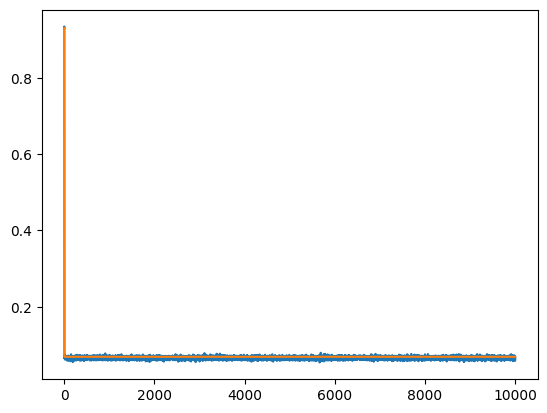

In [7]:
plt.plot(mtr["acuracia_treino"])
plt.plot(mtr["acuracia_teste"])

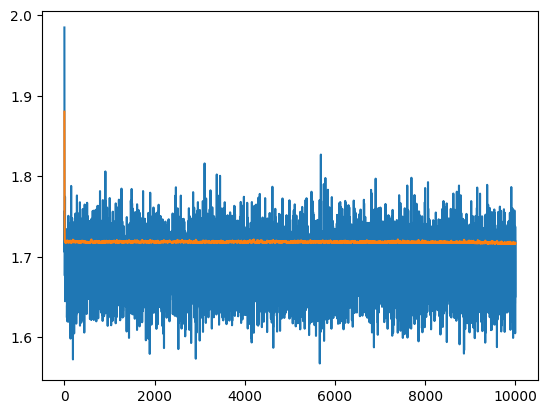

In [8]:
plt.plot(mtr["erro_treino"])
plt.plot(mtr["erro_teste"])

In [9]:
y_pred = predicao(X=X_test,pesos=pesomax).ravel()
y_pred = [int(v>0.5) for v in y_pred]
acu,mtx = metricas(y_test,y_pred)
print(acu,mtx)

0.9312977099236641 [[0.0, 1.0], [0.0, 1.0]]
